This notebook is for the exploration and preprocessing of the data used in the shape classification task of this project. First, the data is loaded and explored, including visualizing example shapes. Next, excess data is discarded, and the training validation datasets are constructed by loading the images, scaling them and splitting them into training and validation sets. Similarly, ground truth labels are extracted and one-hot encoded for CNN use. 

### Imports

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns

sns.set_theme()

## Data Exploration

Data is loaded from this paper: https://www.sciencedirect.com/science/article/pii/S2352340920309847 . The data should be already clean and "trustworthy" for modeling. Hence, we should be able to do minimal processing to make it appropriate.

In [2]:
# Number of files in the data/shapes
image_files = list(Path('data/shapes').glob('*.png'))
print('Number of images found:', len(image_files))

# Print names of first five files
print("Example files")
print('\n'.join([str(x) for x in image_files[:5]]))

Number of images found: 90000
Example files
data/shapes/Nonagon_fb1f8b2e-2a8d-11ea-8123-8363a7ec19e6.png
data/shapes/Hexagon_95d6bf6e-2a95-11ea-8123-8363a7ec19e6.png
data/shapes/Square_037dc95e-2a91-11ea-8123-8363a7ec19e6.png
data/shapes/Triangle_2f39dc38-2a94-11ea-8123-8363a7ec19e6.png
data/shapes/Square_398778f2-2a9a-11ea-8123-8363a7ec19e6.png


It seems that the shape label is included the filename. We can also check this by visualizing the first shape in the data.

## Test image

Below is an example of what an image in the dataset looks like

Shape: Hexagon


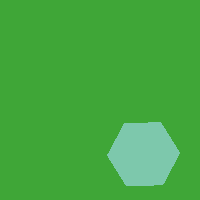

In [3]:

# Load the first image from data/shapes
first_img = image_files[1]

# Get the label from the filename
label = first_img.parts[-1].split("_")[0]

print(f"Shape: {label}")
image = Image.open(first_img)
image

The image seems to be a color image (with 3 channels). This can be confirmed by checking the shape of the array

In [4]:
np.array(image).shape

(200, 200, 3)

The images seem to be in a simple 200 x 200 shape. We dont need the colorscale for classifying simple images, so we could simply convert the images to grayscale. The interesting thing in terms of modeling is that the shapes come in different background colors, meaning that the "non-shape" area wont always be white by default. However, this shouldnt eventually prove to be any problem since the model should anyways catch the shape differences.

From the top of the notebook we saw that there were several different shapes in the dataset.

In [5]:
# Get filenames from image files
filenames = [Path(file).name.split('_')[0] for file in image_files]
unique_labels = np.unique(filenames)
print(unique_labels)
print(f"Number of unique elements: {len(unique_labels)}")


['Circle' 'Heptagon' 'Hexagon' 'Nonagon' 'Octagon' 'Pentagon' 'Square'
 'Star' 'Triangle']
Number of unique elements: 9


In fact, there are 9 unique shapes in the dataset. We do not need all of these shapes for this tutorial task, as we can show a similar mechanism with a smaller number of shapes. Furhter, the network should be easier and faster to train as well. To keep the task a multi-class classification, lets choose three shapes, to model, the circle, square, and triangle. They should be distinct to each other (compared to e.g. heptagon, nonagon), and hence easier to classify. 

*Again note that the purpose of this notebook is not to display high levels of neural net capabilities, but instead, serve as a learning opportunity to show understanding of good data and ML practices.*


## Preprocessing

First we will filter out files that do not contain circles, squares, or triangles

In [6]:
filtered_files = [file for file in image_files if file.name.startswith(("Circle", "Triangle", "Square"))]
filtered_files[:2]

[PosixPath('data/shapes/Square_037dc95e-2a91-11ea-8123-8363a7ec19e6.png'),
 PosixPath('data/shapes/Triangle_2f39dc38-2a94-11ea-8123-8363a7ec19e6.png')]



Next we automate the similar processing for all of the images and save them for later training. In the loop below we load the image, extract its label, convert it to a grayscale image, and normalize it to be between 0 and 1.

The dataset is very large (90 000 images), but 10000 should be enough for our purpose.

In [7]:

data_folder = "data/"
label_list = []
img_list = []

for file_name in tqdm(filtered_files):
    # Get shape label
    label = Path(file_name).name.split('_')[0]
    label_list.append(label)

    # Get image
    image = Image.open(file_name)
    image = np.array(image) / 255.0
    img_list.append(image)

img_list = np.array(img_list)
label_list = np.array(label_list)


  0%|          | 0/30000 [00:00<?, ?it/s]

In [8]:
label_list.shape
img_list.shape

(30000, 200, 200, 3)

Lets also encode the labels: Currently they are string-categories, but for them to be understood by the model, they should be one-hot encoded (the output of the CNN is a vector showing the activation of each shape).

In [9]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(label_list)

onehot_encoder = OneHotEncoder(sparse=False)
labels_encoded = onehot_encoder.fit_transform(labels_encoded.reshape(-1, 1))
labels_encoded[:3]

/Users/rasmus.siljander/opt/anaconda3/envs/shape_recognition/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Finally, lets split the data and save them for later training. The file type of choice is the numpy internal tensor format, `.npy`, which was tested as it was a new file extension to me.

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(img_list, labels_encoded, test_size=0.2, random_state=42)

# Print the sizes of the train and test sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))


Train set size: 24000
Test set size: 6000


In [11]:
# Create folder data/processed with pathlib
processed_folder = Path("data") / "processed"
processed_folder.mkdir(parents=True, exist_ok=True)

# Save results to processed folder
np.save(processed_folder / 'X_train.npy', X_train)
np.save(processed_folder / 'X_test.npy', X_test)
np.save(processed_folder / 'y_train.npy', y_train)
np.save(processed_folder / 'y_test.npy', y_test)


Before moving on, lets visualize the class frequencies and test the data to ensure that the processing was correct

In [12]:
np.argmax(y_train, axis=1)

array([2, 2, 2, ..., 1, 2, 1])

<Axes: >

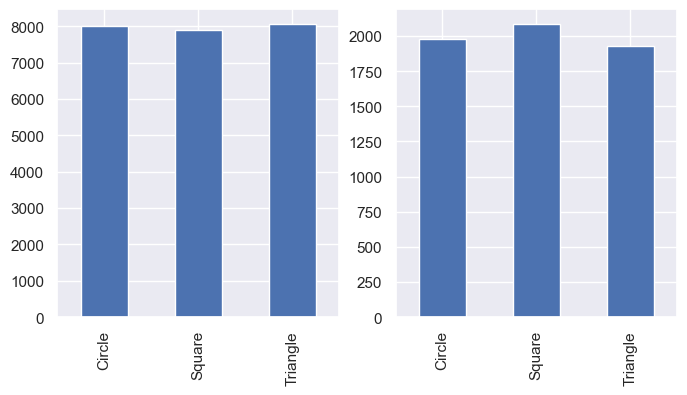

In [13]:
shapes = ["Circle", "Square", "Triangle"]

fig, axs = plt.subplots(1,2, figsize=(8,4))

labels = pd.Series([shapes[i] for i in np.argmax(y_train, axis=1)])
label_counts = labels.value_counts().sort_index()
label_counts.plot(kind='bar', ax=axs[0])

labels = pd.Series([shapes[i] for i in np.argmax(y_test, axis=1)])
label_counts = labels.value_counts().sort_index()
label_counts.plot(kind='bar', ax=axs[1])

The distributions are slighty unbalanced, which might cause some slight issues in model performance during training. However, the distributions are not so drastic, and should be fine for the purpose of this tutorial model.

[0. 0. 1.]


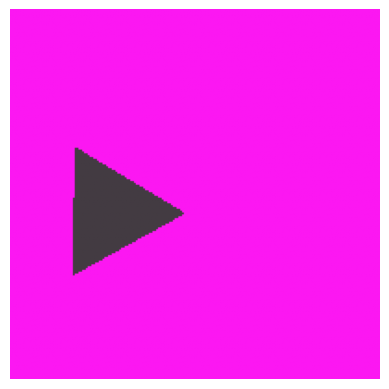

In [14]:
print(y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.axis('off')
plt.show()
